# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from sqlalchemy import create_engine
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
%matplotlib inline
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# !pip install -U scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naeem.ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naeem.ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\naeem.ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26211,30261,The training demonstrated how to enhance micro...,None,news,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26212,30262,A suitable candidate has been selected and OCH...,None,news,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26213,30263,"Proshika, operating in Cox's Bazar municipalit...",None,news,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26214,30264,"Some 2,000 women protesting against the conduc...",None,news,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


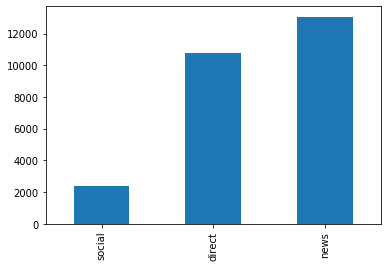

In [2]:
# load data from database
engine = create_engine('sqlite:///disaster_reponse.db')
df = pd.read_sql('combined_df',con=engine)
X = df['message']
Y = df.iloc[:,4:]
df.genre.value_counts().sort_values().plot(kind = 'bar')
df

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return 1
        return 0

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
model = pipeline.fit(X_train,y_train)
y_pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
from sklearn.metrics import classification_report
y_pred_df = pd.DataFrame(y_pred, columns=Y.columns)
for i,column in enumerate(Y.columns):
    print(column,classification_report(y_test[column], y_pred_df[column]))


related               precision    recall  f1-score   support

         0.0       0.62      0.35      0.45      1547
         1.0       0.82      0.93      0.87      4963
         2.0       0.40      0.05      0.08        44

    accuracy                           0.79      6554
   macro avg       0.61      0.44      0.47      6554
weighted avg       0.77      0.79      0.77      6554

request               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      5389
         1.0       0.85      0.38      0.53      1165

    accuracy                           0.88      6554
   macro avg       0.86      0.68      0.73      6554
weighted avg       0.87      0.88      0.86      6554

offer               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6534
         1.0       0.00      0.00      0.00        20

    accuracy                           1.00      6554
   macro avg       0.50      0.50      0.50      655

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6343
         1.0       0.83      0.05      0.09       211

    accuracy                           0.97      6554
   macro avg       0.90      0.52      0.54      6554
weighted avg       0.96      0.97      0.96      6554

child_alone               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6554

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00      1.00      6554

water               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      6112
         1.0       0.83      0.20      0.33       442

    accuracy                           0.94      6554
   macro avg       0.89      0.60      0.65      6554
weighted avg       0.94      0.94      0.93      6554

food               precision    recall  f1-score   sup

direct_report               precision    recall  f1-score   support

         0.0       0.86      0.98      0.91      5292
         1.0       0.77      0.32      0.46      1262

    accuracy                           0.85      6554
   macro avg       0.82      0.65      0.68      6554
weighted avg       0.84      0.85      0.83      6554



### 6. Improve your model
Use grid search to find better parameters. 

In [7]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'starting_verb': 0.5},
            {'text_pipeline': 0.5, 'starting_verb': 1},
            {'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, verbose=3)

    return cv

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
def load_data():
    engine = create_engine('sqlite:///disaster_reponse.db')
    df = pd.read_sql('combined_df',con=engine)
    X = df['message']
    Y = df.iloc[:,4:]
    return X, Y
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
main()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.237, total= 3.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_p

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.239, total= 3.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.7min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.244, total= 3.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.247, total= 5.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.254, total= 2.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.254, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.263, total= 3.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.245, total= 3.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.261, total= 2.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.261, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.249, total= 2.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.242, total= 3.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.244, total= 5.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.254, total= 2.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weight

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.247, total= 2.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.255, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.241, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.255, total= 2.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.259, total= 2.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.246, total= 2.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.240, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.240, total= 5.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.251, total= 2.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.248, total= 2.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.260, total= 3.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.238, total= 3.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.255, total= 2.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.261, total= 2.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.247, total= 2.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.249, total= 5.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.245, total= 9.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.260, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.253, total= 5.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.262, total= 5.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.244, total= 5.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.258, total= 4.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.260, total= 5.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.253, total= 4.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.245, total= 7.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.247, total=10.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.257, total= 5.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.250, total= 5.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.260, total= 5.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.241, total= 7.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.252, total= 4.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.264, total= 5.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.247, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.245, total= 5.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.240, total= 9.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.258, total= 4.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.248, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transf

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.259, total= 5.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transf

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.244, total= 5.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.256, total= 4.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.261, total= 5.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.246, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.245, total=10.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.247, total=17.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.260, total= 8.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.258, total= 8.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.260, total= 9.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.247, total= 9.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.258, total= 8.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.262, total= 9.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_w

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.254, total= 8.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.242, total=10.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weig

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.247, total=17.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.256, total= 8.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_wei

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.255, total= 8.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.260, total= 9.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=True, features__text_pipeline__vect__max_df=1.0, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.244, total= 9.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.261, total= 7.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.266, total= 8.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.249, total= 8.0min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.5, features__text_pipeline__vect__max_features=10000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5}, score=0.244, total= 9.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 1), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.5, 'starting_verb': 1}, score=0.245, total=17.2min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=None, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 1), features__transformer_weights={'text_pipeline': 0.8, 'starting_verb': 1}, score=0.254, total= 7.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transformer_weights={'text_pipeline': 1, 'starting_verb': 0.5} 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__vect__max_df=0.75, features__text_pipeline__vect__max_features=5000, features__text_pipeline__vect__ngram_range=(1, 2), features__transform

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.